In [1]:
import torch

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


#### 설치

In [3]:
pip install tqdm

     |████████████████████████████████| 78 kB 1.1 MB/s             
Note: you may need to restart the kernel to use updated packages.


In [108]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [479]:
pip install scikit-learn

     |████████████████████████████████| 22.2 MB 13.0 MB/s            
     |████████████████████████████████| 25.9 MB 30.2 MB/s            
     |████████████████████████████████| 309 kB 42.8 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [73]:
pip install torchmetrics

     |████████████████████████████████| 409 kB 11.4 MB/s            
Note: you may need to restart the kernel to use updated packages.


#### 난수 고정

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# 학습시작

### 라이브러리

---

In [140]:
import torch.nn as nn                     
import torch.nn.functional as F           # 손실함수

import torch.optim as optim               # optimizer
from torch.utils.data import DataLoader


import torchvision
import torchvision.transforms as transforms

import splitfolders as sf

from tqdm import tqdm
import torch.optim as optim


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import os

from glob import glob
import numpy as np

import torchmetrics
import math

## 데이터

---

In [3]:
# 정규화 설정
transform = transforms.Compose( # 여러단계로 변환 시 묶어서 사용할 수 있게 함.
    [transforms.ToTensor(), # 데이터를 Tensor로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

# batch size 설정
batch_size = 13

##### 학습 데이터 분할하기

https://deep-learning-study.tistory.com/474

In [4]:
test0_ds = torchvision.datasets.ImageFolder(root = 'apple_dataset/train',
                                             transform = transform)

In [5]:
# test0_ds의 인덱스를 두 그룹으로 분할
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit sample the data in same proportion of labels
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.7, random_state=0)
        # n_splits=분할할 파일 수

indices = list(range(len(test0_ds)))
y_test0 = [y for _, y in test0_ds]

for test_index, val_index in sss.split(indices, y_test0):
    print('test:', test_index, 'val:', val_index)
    print(len(val_index), len(test_index))

test: [4714 2999 6199 ...    8 3190 6257] val: [2018 3041 4589 ... 3226 3643 4981]
1922 4482


In [6]:
# test0_ds로부터 두 dataset을 생성
# create two datasets from test0_ds
from torch.utils.data import Subset

# if test0_ds is updated, val_ds and test_ds are updated.
# because val_ds and test_ds are a subset of train_ds
val_ds = Subset(test0_ds, val_index)
train_ds = Subset(test0_ds, test_index)

In [7]:
# val_ds와 test_ds의 카테고리당 이미지수 확인하기
# count the number of images per class in val_ds and test_ds
import collections
import numpy as np

y_train = [y for _, y in train_ds]
y_val = [y for _, y in val_ds]

counter_train = collections.Counter(y_train)
counter_val = collections.Counter(y_val)
print(counter_train)
print(counter_val)

Counter({12: 470, 5: 345, 11: 345, 8: 344, 0: 344, 3: 344, 7: 344, 10: 343, 4: 337, 2: 336, 6: 319, 1: 311, 9: 300})
Counter({12: 202, 8: 148, 3: 148, 7: 148, 0: 148, 11: 147, 10: 147, 5: 147, 4: 144, 2: 144, 6: 137, 1: 133, 9: 129})


image indices: [2732 2607 1653 3264]
torch.Size([3, 102, 405])


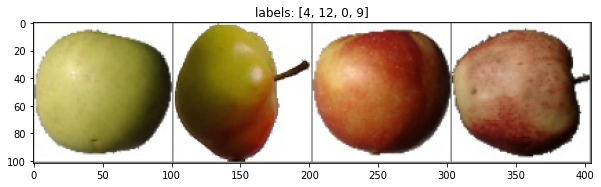

In [8]:
# train dataset과 validation dataset의 이미지 확인하기
from torchvision import utils
np.random.seed(0)

# define helper function
def show(img, y=None, color=True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1, 2, 0))

    plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))

# pick random samples
grid_size = 4 #칸 개수
rnd_inds = np.random.randint(0, len(train_ds), grid_size) 
print('image indices:', rnd_inds)

# create a grid from the sample images
x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=1)
print(x_grid.shape)

plt.figure(figsize=(10.0, 10.0))
show(x_grid, y_grid)

#### 데이터 세트 불러오기

In [12]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size*2,
                                         shuffle=False, num_workers=2)


testset = torchvision.datasets.ImageFolder(root = 'apple_dataset/test',
                                             transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### 데이터 세트 분석

---

#### 데이터 비율 및 학습 데이터 클래스별 데이터 수

train : validation = 7 : 3


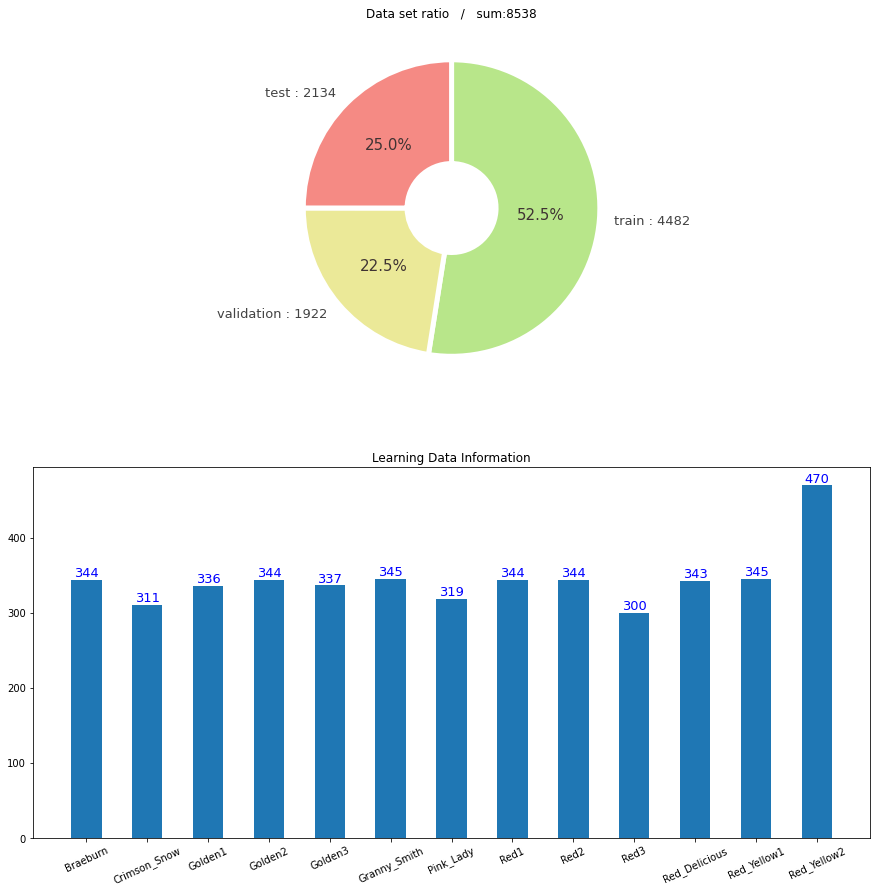

filename extension:.jpg / image size:(100, 100)


In [31]:
train_file_list = glob('apple_dataset/train/Apple_*')
test_list = glob('apple_dataset/test/Apple_*/**')

plt.rcParams['figure.figsize'] = (15.0, 15.0)


# 학습 이미지 개수 확인하기
plt.subplot(2, 1, 1)
all_cnt = len(train_ds) + len(val_ds) + len(test_list)

ratio=[len(train_ds), len(val_ds), len(test_list)]   # 차트 값 설정
labels = [f'train : {len(train_ds)}', f'validation : {len(val_ds)}', f'test : {len(test_list)}']   #라벨 이름
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}    #차트 스타일
colors_pie = ['#b8e68a', '#ebe998', '#f58a84']

plt.title(f'Data set ratio   /   sum:{all_cnt}')
patches, texts, autotexts = plt.pie(ratio, 
                                    labels=labels, 
                                    colors=colors_pie,
                                    autopct='%.1f%%', 
                                    startangle=90, 
                                    counterclock=False, 
                                    wedgeprops=wedgeprops)

for t in texts: 
    t.set_fontsize(13)
    t.set_color('#434343')

for t in autotexts:
    t.set_fontsize(15)
    t.set_color('#3f3333')

print('train : validation = 7 : 3')


# 학습 데이터 정보 출력
file_name = list(range(13))
count_order = list(range(13))

len(file_name)
for i in range(13):
    name = str(train_file_list[i])
    file_name[i] = name[26:]
    
    count_order[i] = counter_train[i]


x = np.arange(13)
plt.subplot(2, 1, 2)
    
plt.xticks(x, file_name, rotation=25)
plt.bar(x, count_order, width=0.5)


for i, v in enumerate(x):
    plt.text(v, count_order[i], count_order[i],   # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 13, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)


plt.title('Learning Data Information')

plt.show()


file_dir = os.listdir(train_file_list[i])
img_extension = os.path.splitext(file_dir[0])[1] 

images = glob(f'{train_file_list[i]}/*')
image = Image.open(f'{images[i]}')
img_size = image.size 

print(f'filename extension:{img_extension} / image size:{img_size}')

#### 샘플 출력

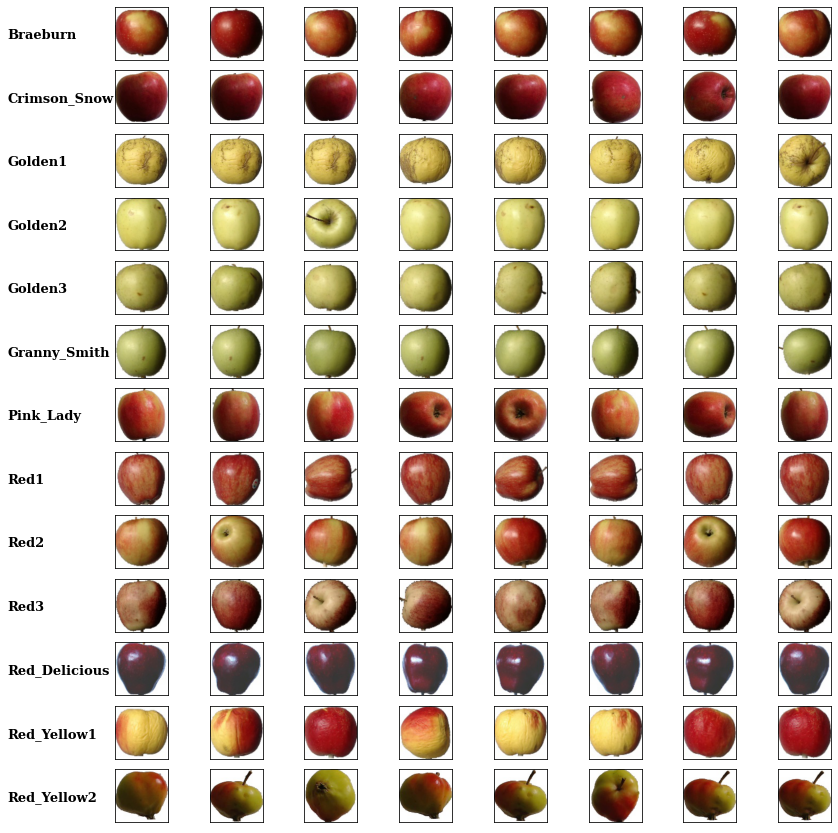

In [11]:
import random

img_i = 0
num_i = 0

plt.rcParams['figure.figsize'] = (15.0, 15.0)
font = {'family': 'serif',
      'weight': 'bold',
      'size': 13}

for j in range(13): 
    num = random.sample(range(0, 300), 9)   
                        # 300 : 위에서 출력한 클래스별 데이터 개수중 가장 적은 데이터 개수
    
    for i in range(9) : 
        img_i += 1
        plt.subplot(13, 9, img_i)
        
        if(i == 0):
            plt.text(0, 0.4, file_name[j], fontdict=font)
            plt.axis('off')
        
        if(i != 0):
            num_i = num[i]
            images_dir = glob(f'{train_file_list[j]}/*')
            image = Image.open(f'{images_dir[num_i]}')
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
    num = []

plt.show()

## 모델

---

#### 모델 불러오기

In [9]:
# mobilenetV3 불러오기
import torchvision.models as models

model = models.mobilenet_v3_small(num_classes=13).to(device)

In [11]:
# 모델 정보 출력. 11개의 층으로 이루어짐.
model

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

#### 모델 학습

In [13]:
criterion = nn.CrossEntropyLoss()   # 손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # optimizer:SGD사용    

def accuracy_F(loader, model):
    acc = 0
    total = 0
    
    for data, labels in loader:
            outputs = model(data.cuda()) 
            
            _, predictions = torch.max(outputs, 1) \
            
            for label, prediction in zip(labels.cpu(), predictions.cpu()): # zip:튜플로 만들어줌
                if label == prediction:  # 예측 결과와 정답 비교
                    acc += 1 # 맞춘 횟수 세기
                total += 1
    return float(acc) / total

In [16]:
epoch_num = 10

train_loss = list(range(epoch_num))
val_loss = list(range(epoch_num))

accuracy_train = list(range(epoch_num))
accuracy_val = list(range(epoch_num))


for epoch in range(epoch_num):   # batch_size : 13
    running_loss = 0.0
    model.train()
    
    for data in tqdm(trainloader):
        inputs, labels = data # [inputs, labels]의 목록인 data로부터 입력을 받은 후
        
        optimizer.zero_grad() # 변화도(Gradient) 매개변수를 0으로 만들고

        outputs = model(inputs.cuda()) # 순전파
        
        loss = criterion(outputs.cpu(), labels) # criterion : 손실함수
        loss.backward() # 자동 미분, 역전파
        optimizer.step() # 최적화 반영
        
        # loss 합
        running_loss += loss.item()
     
    model.eval()
    
    with torch.no_grad():
        # loss
        valid_loss = sum(criterion(model(inputs.cuda()), labels.cuda()) for inputs, labels in valloader)
    
    train_loss[epoch] = running_loss / len(trainloader)
    val_loss[epoch] = valid_loss / len(valloader)
    
    # accuracy
    accuracy_train[epoch] = accuracy_F(trainloader, model)
    accuracy_val[epoch] = accuracy_F(valloader, model)
    
    print('{0} / tarin loss : {1:.3f} / validaion loss : {2:.3f} / train_accuracy : {3:.3f} / val_accuracy : {4:.3f}'
         .format(epoch, train_loss[epoch], val_loss[epoch], accuracy_train[epoch], accuracy_val[epoch]))


print('Finished Training')
# print(output)

100%|██████████| 345/345 [00:11<00:00, 28.94it/s]


0 / tarin loss : 1.058 / validaion loss : 0.554 / train_accuracy : 0.905 / val_accuracy : 0.901


100%|██████████| 345/345 [00:12<00:00, 28.09it/s]


1 / tarin loss : 0.440 / validaion loss : 0.120 / train_accuracy : 0.991 / val_accuracy : 0.987


100%|██████████| 345/345 [00:11<00:00, 29.80it/s]


2 / tarin loss : 0.232 / validaion loss : 0.080 / train_accuracy : 0.988 / val_accuracy : 0.989


100%|██████████| 345/345 [00:11<00:00, 30.76it/s]


3 / tarin loss : 0.153 / validaion loss : 0.016 / train_accuracy : 1.000 / val_accuracy : 0.999


100%|██████████| 345/345 [00:11<00:00, 29.77it/s]


4 / tarin loss : 0.097 / validaion loss : 0.172 / train_accuracy : 0.936 / val_accuracy : 0.944


100%|██████████| 345/345 [00:12<00:00, 28.57it/s]


5 / tarin loss : 0.072 / validaion loss : 0.014 / train_accuracy : 0.999 / val_accuracy : 0.999


100%|██████████| 345/345 [00:11<00:00, 29.91it/s]


6 / tarin loss : 0.074 / validaion loss : 0.002 / train_accuracy : 1.000 / val_accuracy : 1.000


100%|██████████| 345/345 [00:11<00:00, 29.71it/s]


7 / tarin loss : 0.068 / validaion loss : 0.008 / train_accuracy : 1.000 / val_accuracy : 0.998


100%|██████████| 345/345 [00:11<00:00, 29.70it/s]


8 / tarin loss : 0.060 / validaion loss : 0.015 / train_accuracy : 0.997 / val_accuracy : 0.997


100%|██████████| 345/345 [00:11<00:00, 29.08it/s]


9 / tarin loss : 0.038 / validaion loss : 0.002 / train_accuracy : 1.000 / val_accuracy : 1.000
Finished Training


###### 오류 코드

In [101]:
epoch_num = 10
train_loss = list(range(epoch_num))
val_loss = list(range(epoch_num))

TP = 0
total = 0

global output


for epoch in range(epoch_num):   # batch_size : 13

    running_loss = 0.0
    model.train()
    for data in tqdm(trainloader):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs.cuda())
        
        loss = criterion(outputs.cpu(), labels) # criterion : 손실함수
        loss.backward() # 자동 미분, 역전파
        optimizer.step() # 최적화 반영
        running_loss += loss.item()
        output = outputs
     
    model.eval()
    
    
    # validaion loss
    with torch.no_grad():
        valid_loss = sum(criterion(model(inputs.cuda()), labels.cuda()) for inputs, labels in valloader)
    val_loss[epoch] = valid_loss / len(valloader)
    train_loss[epoch] = running_loss / len(trainloader)
    
    
    #Accuracy
    _, predictions = torch.max(outputs, 1) 
    # _부분은 예측한 이미지와 정답 이미지 tensor가 2개 넘어오는 듯
    # predictions는 [예측라벨, 정답라벨] 넘어오는 듯
    output = torch.max(outputs)
        
    # 각 분류별로 올바른 예측 수를 모읍니다
    for label, prediction in zip(labels.cpu(), predictions.cpu()): # zip:튜플로 만들어줌
        if label == prediction:  # 예측 결과와 정답 비교
            TP += 1 # 맞춘 횟수 세기
        total += 1  # 총 개수 세기
    accuracy = float(TP) / total
    
    print('{0} / tarin loss : {1:.1f} / validaion loss : {2:.1f} / accuracy : {3:.1f}'
         .format(epoch, train_loss[epoch], val_loss[epoch], accuracy))

print('Finished Training')
# print(output)

 81%|████████  | 318/394 [00:22<00:05, 14.17it/s]


RuntimeError: DataLoader worker (pid 20340) is killed by signal: Segmentation fault. 

##### 학습 현황 확인

https://gaussian37.github.io/dl-pytorch-observe/

<function matplotlib.pyplot.show(close=None, block=None)>

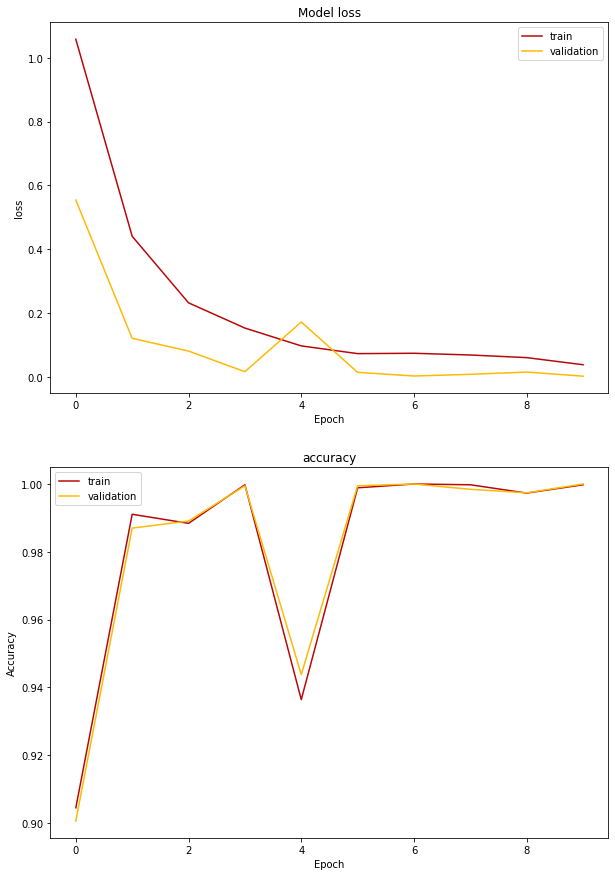

In [28]:
plt.rcParams['figure.figsize'] = (10.0, 15.0)

# loss 시각화
plt.subplot(2, 1, 1)
plt.title('Model loss')
plt.plot(train_loss, color = '#b80606')
plt.plot(val_loss, color = '#fcba03')

plt.xlabel('Epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'])


# accuracy 시각화
plt.subplot(2, 1, 2)
plt.title('accuracy')
plt.plot(accuracy_train, color='#b80606')
plt.plot(accuracy_val, color='#fcba03')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(['train', 'validation'])


plt.show

#### 전체 데이터셋에 대해 어떻게 작동하는가

In [ ]:
outputs = model(images.cuda())

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(13)))

Predicted:  Apple Pink Lady Apple Red Yellow 2 Apple Pink Lady Apple Golden 1


#### 각 분류별 정확도 출력

In [123]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
f1_s = torchmetrics.F1Score(task="multiclass", num_classes=13)
F1_sum = list(range(len(file_name)))
F1_total = list(range(len(file_name)))
F1_test = list(range(len(file_name)))

confusion_m = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=13)
confu_sum = list(range(len(file_name)))
confu_total = list(range(len(file_name)))
confu_test = list(range(len(file_name)))

global nuuuuum

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        outputs = model(images.cuda())
        # ouputs는 배치 사이즈 개수 만큼의 텐서 개수 중 모델이 각 클래스별로 예측한 값을 텐서로 보여줌
        # 때문에 배치(13) * 클래스(13) 사이즈로 나옴
        
        _, predictions = torch.max(outputs, 1) 
        # _부분은 
        # predictions는 tensor[예측라벨, 정답라벨] 넘어오는 듯
        
        for label, prediction in zip(labels.cpu(), predictions.cpu()):
            F1_sum[label] += f1_s(predictions.cpu(), labels.cpu())
            F1_total[label] += 1 
            
            confu_sum[label] += confusion_m(predictions.cpu(), labels.cpu())
            confu_total[label] += 1
            
            
        F1_test[label]= float(F1_sum[label]) / F1_total[label] 
        confu_test[label]= confu_sum[label] / confu_total[label]

print('Finish')

100%|██████████| 165/165 [00:03<00:00, 42.01it/s]

Finish


In [67]:
pred_tensor

tensor([15.1893, 15.6341, 16.1145, 15.5447, 14.9897, 15.3589, 13.2414, 17.5327,
        16.0989, 16.4382, 15.0519, 15.4670, 14.7911], device='cuda:0')

In [70]:
outputs.shape

torch.Size([13, 13])

In [69]:
outputs

tensor([[ 15.1893,   5.0775, -12.2357,  -7.1285,  -4.7495,  -2.2551,   4.0223,
           5.9936,   5.3782,   2.3353,  -5.8348,  -5.1547,   0.2271],
        [ 15.6341,   4.8643, -12.4762,  -7.4834,  -4.7448,  -2.5938,   3.9882,
           6.2583,   5.8783,   2.6053,  -6.2336,  -5.0979,   0.2917],
        [ 16.1145,   5.0843, -12.9023,  -7.5863,  -5.0792,  -2.7276,   4.3764,
           6.4181,   5.8803,   2.8096,  -6.4605,  -5.4700,   0.4637],
        [ 15.5447,   4.6204, -12.4042,  -7.3490,  -4.4180,  -2.2254,   4.1377,
           5.7193,   5.7983,   2.5977,  -6.5315,  -5.4291,   0.8285],
        [ 14.9897,   4.3050, -11.8614,  -7.2904,  -3.9374,  -2.1660,   3.4833,
           5.5370,   5.9592,   2.4564,  -6.3870,  -4.8992,   0.6671],
        [ 15.3589,   4.7187, -12.1865,  -7.4809,  -4.4144,  -2.5878,   3.4884,
           6.1014,   6.0498,   2.6553,  -6.2909,  -4.8311,   0.2925],
        [ 13.2414,   3.9271, -10.6994,  -6.9181,  -3.5383,  -2.1445,   2.8262,
           5.4333,   5.5858

In [68]:
predictions

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [72]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [64]:
lll.shape

torch.Size([2])

In [ ]:
correct_pred

{'Braeburn': 135,
 'Crimson_Snow': 148,
 'Golden1': 160,
 'Golden2': 164,
 'Golden3': 161,
 'Granny_Smith': 155,
 'Pink_Lady': 152,
 'Red1': 164,
 'Red2': 155,
 'Red3': 144,
 'Red_Delicious': 166,
 'Red_Yellow1': 164,
 'Red_Yellow2': 219}

마지막 가장 실행 결과  
predictions: tensor([12, 12], device='cuda:0')-> 왜 두개 나오지  
ouputs: tensor(26.8530, device='cuda:0')-> 왜 한개 나오지  
_ :  tensor([25.6138, 26.8530], device='cuda:0')-> 왜 두개 나오지  
labels : tensor[12, 12]  
images : tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

##### 에러 코드 : 해결은 됨 이유 모름

In [ ]:
# 완전 원본 코드(수정 X)
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        outputs = model(images.cuda())
        
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in file_name}
total_pred = {classname: 0 for classname in file_name}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        outputs = model(images.cuda())
        number, predictions = torch.max(outputs, 1)
        predictions.cpu()
        ouput = predictions
        # 각 분류별로 올바른 예측 수를 모읍니다
        for number, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print(pred, number)

  0%|          | 0/165 [00:00<?, ?it/s]


RuntimeError: t == DeviceType::CUDAINTERNAL ASSERT FAILED at "../c10/cuda/impl/CUDAGuardImpl.h":24, please report a bug to PyTorch. 

## 결과 시각화
---

### 모델 평가 지표

In [124]:
for i in x:
    print(F1_test[i])

0.8141028086344401
1.0
1.0
1.0
1.0
0.9426752564254081
1.0
1.0
0.9440994736570749
1.0
1.0
1.0
1.0


##### f1-score

<function matplotlib.pyplot.show(close=None, block=None)>

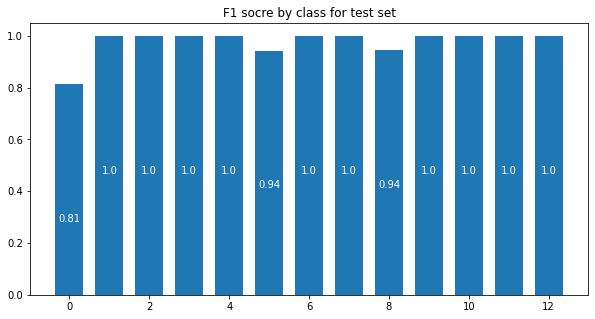

In [149]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)

x=list(range(13))
plt.bar(x, F1_test, width = 0.7)
plt.title('F1 socre by class for test set')

for i, v in enumerate(x):
    plt.text(v, F1_test[i]-0.5, round(F1_test[i], 2),  #좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='white',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='top')   # verticalalignment (top, center, bottom)

plt.show

##### 혼동 행렬

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)

x=list(range(13))
plt.bar(x, F1_test, width = 0.7)
plt.title('F1 socre by class for test set')

for i, v in enumerate(x):
    plt.text(v, F1_test[i]-0.5, round(F1_test[i], 2),  #좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='white',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='top')   # verticalalignment (top, center, bottom)

plt.show

https://rabo0313.tistory.com/entry/ML-%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EC%84%B1%EB%8A%A5-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-Confusion-Matrix-accuracy-precision-recall-f1-score-ROC-AUC-curve

https://skillmemory.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EB%B6%84%EB%A5%98-%ED%98%BC%EB%8F%99-%ED%96%89%EB%A0%ACConfusion-matrix

https://truman.tistory.com/179